# Intro Task, Object Localization

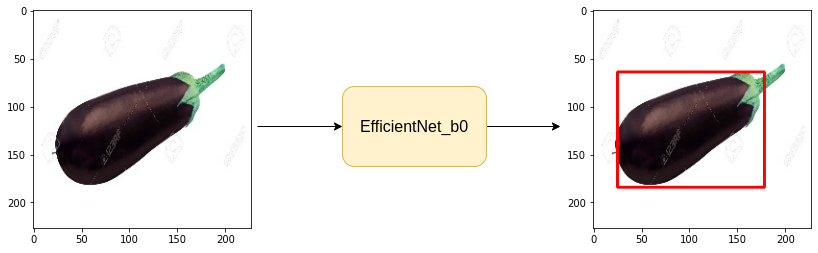

In [1]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-4b23_vpf
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-4b23_vpf
  Resolved https://github.com/albumentations-team/albumentations to commit d47389cd8c40f7f7b5a0ee777a204e251484ed11
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 28.9 MB/s eta 0:00:00
  Created wheel for albumentations: filename=albumentations-1.4.4-py3-none-any.whl size=153188 sha256=d8c85c5bd620760196725b1128456110dae132757de3cfc842491b3795fe9277
  Stored in directory: /tmp/pip-ephem-wheel-cache-d3h7aj86/wheels/51/4d/ab/5aafa8b980086fbc362946de7da4aa

In [2]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 6.91 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [5]:
  csv_file = "/content/object-localization-dataset/train.csv"
  data_dir = "/content/object-localization-dataset/"

  device = 'cuda'

  batch_size = 16
  img_size = 140

  lr=0.001
  epochs=40
  model_name = 'efficientnet_b0'

  num_cor=4;

In [6]:
df=pd.read_csv(csv_file)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

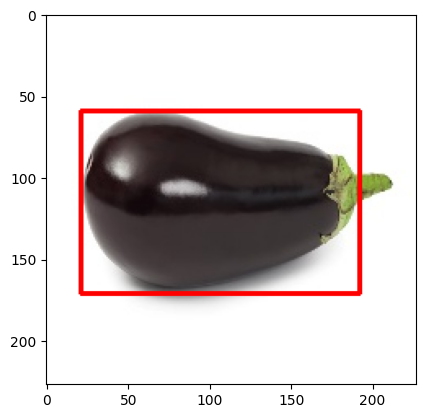

In [9]:
row = df.iloc[184]
img=cv2.imread(data_dir + row.img_path)
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1=(row.xmin, row.ymin)
pt2=(row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img, pt1, pt2, (255, 0, 0), 2)
plt.imshow(bnd_box_img)

In [10]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state = 42)

# Augmentations

In [11]:
import albumentations as A

In [32]:
train_augs = A.Compose([
    A.Resize(img_size, img_size),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields = ['class_labels']))

valid_augs = A.Compose([
    A.Resize(img_size, img_size)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields = ['class_labels']))

# Create Custom Dataset

In [33]:
class ObjLocDataset(torch.utils.data.Dataset):
  def __init__(self, df, albumentations=None):
    self.df=df
    self.albumenatations = albumentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row=self.df.iloc[idx]

    xmin=row.xmin
    ymin=row.ymin
    xmax=row.xmax
    ymax=row.ymax

    bbox=[[xmin, ymin, xmax, ymax]]

    img_path = data_dir + row.img_path
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.albumenatations:
      data = self.albumenatations(image=img, bboxes=bbox , class_labels = [None])
      img=data['image']
      bbox=data['bboxes'][0]

    img = torch.from_numpy(img).permute(2, 0, 1)/255.0
    bbox=torch.Tensor(bbox)

    return img, bbox

In [34]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(test_df, valid_augs)

In [35]:
print(f"Length of Train Set:{len(trainset)}")
print(f"Length of Train Set:{len(validset)}")

Length of Train Set:148
Length of Train Set:38


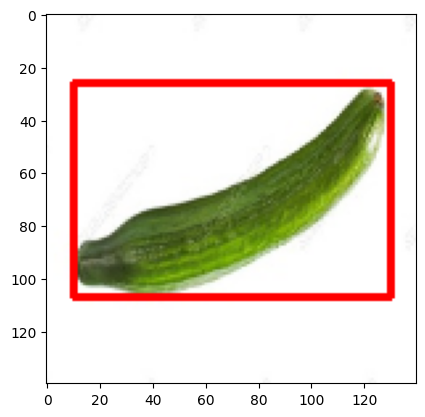

In [36]:
img, bbox = trainset[6]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [39]:
trainloader=torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader=torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=False)

In [40]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [41]:
for images, bboxes in trainloader:
  break;


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [42]:
from torch import nn
import timm

In [43]:
class ObjLocModel(nn.Module):
  def __init__(self):
    super(ObjLocModel, self).__init__()
    self.backbone=timm.create_model(model_name,  pretrained=True, num_classes=4)

  def forward(self, images, gt_bboxes=None):
    bboxes = self.backbone(images)

    if gt_bboxes!=None:
      loss=nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes, loss

    return bboxes

In [46]:
model = ObjLocModel()
model.to(device)

ObjLocModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(

In [47]:
random_img=torch.rand(1, 3, 140, 140).to(device)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [49]:
def train_fn(model, dataloader, optimizer):
  total_loss=0.0
  model.train() #dropout ON

  for data in tqdm(dataloader):
    images, gt_bboxes=data
    images, gt_bboxes=images.to(device), gt_bboxes.to(device)

    bboxes, loss = model(images, gt_bboxes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(dataloader)

In [51]:
def eval_fn(model, dataloader):
  total_loss=0.0
  model.eval() #dropout OFF

  with torch.no_grad():
    for data in tqdm(dataloader):
      images, gt_bboxes=data
      images, gt_bboxes=images.to(device), gt_bboxes.to(device)

      bboxes, loss = model(images, gt_bboxes)

      total_loss += loss.item()

    return total_loss/len(dataloader)

#Training Loop

In [52]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [54]:
best_valid_loss = np.Inf

for i in range(epochs):
  train_loss=train_fn(model, trainloader, optimizer)
  valid_loss=eval_fn(model, validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("Weights are saved")
    best_valid_loss = valid_loss

  print(f"Epoch: {i+1} train loss : {train_loss} valid loss: {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch: 1 train loss : 1964.38291015625 valid loss: 2738.489501953125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch: 2 train loss : 1128.328759765625 valid loss: 599.9633382161459


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch: 3 train loss : 711.2367614746094 valid loss: 192.7359873453776


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch: 4 train loss : 548.6304626464844 valid loss: 167.4738540649414


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch: 5 train loss : 395.58768157958986 valid loss: 162.88987477620444


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch: 6 train loss : 295.4888610839844 valid loss: 152.90130615234375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 7 train loss : 243.60025177001953 valid loss: 187.16242472330728


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch: 8 train loss : 192.1823272705078 valid loss: 152.3696085611979


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 9 train loss : 155.12013320922853 valid loss: 166.5544179280599


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch: 10 train loss : 138.6355941772461 valid loss: 109.84081776936848


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 11 train loss : 107.1234230041504 valid loss: 132.01270294189453


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch: 12 train loss : 91.87427825927735 valid loss: 102.21390024820964


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch: 13 train loss : 93.99510917663574 valid loss: 90.14703114827473


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 14 train loss : 87.90285682678223 valid loss: 158.03123982747397


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 15 train loss : 92.3208251953125 valid loss: 101.62100728352864


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch: 16 train loss : 78.82815933227539 valid loss: 84.99427286783855


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 17 train loss : 67.61728439331054 valid loss: 97.66653442382812


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch: 18 train loss : 59.55725021362305 valid loss: 72.42905044555664


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 19 train loss : 58.71484375 valid loss: 84.22350056966145


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 20 train loss : 72.14190711975098 valid loss: 76.01377360026042


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch: 21 train loss : 71.23388900756837 valid loss: 57.53895060221354


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 22 train loss : 55.6478458404541 valid loss: 75.43332417805989


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 23 train loss : 53.36581153869629 valid loss: 69.67423756917317


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 24 train loss : 63.679737663269044 valid loss: 57.73434702555338


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 25 train loss : 55.076887702941896 valid loss: 160.12019856770834


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch: 26 train loss : 57.924746704101565 valid loss: 55.936875661214195


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 27 train loss : 48.151893615722656 valid loss: 76.8399658203125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 28 train loss : 60.33920822143555 valid loss: 62.4504280090332


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch: 29 train loss : 37.14559688568115 valid loss: 51.851409912109375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 30 train loss : 52.47546558380127 valid loss: 61.333930333455406


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 31 train loss : 38.85477485656738 valid loss: 67.0534159342448


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 32 train loss : 47.637905502319335 valid loss: 72.97419738769531


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 33 train loss : 35.42448825836182 valid loss: 60.59194819132487


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 34 train loss : 47.28806743621826 valid loss: 77.3193868001302


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 35 train loss : 40.37624721527099 valid loss: 57.539788564046226


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 36 train loss : 34.36204299926758 valid loss: 51.92001978556315


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 37 train loss : 46.55400142669678 valid loss: 97.17094294230144


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 38 train loss : 34.41656551361084 valid loss: 82.39941024780273


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 39 train loss : 49.751994132995605 valid loss: 71.77310053507487


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 40 train loss : 41.71836624145508 valid loss: 59.42990366617838


#Inference

In [55]:
import utils

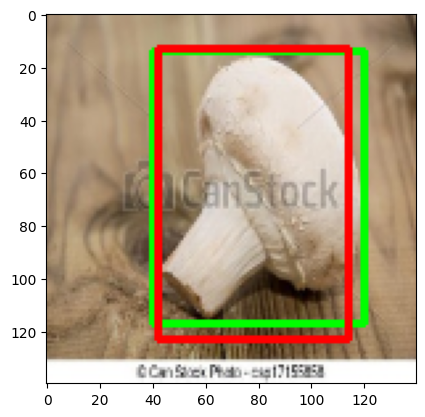

In [57]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
  image, gt_bbox = validset[23]
  image=image.unsqueeze(0).to(device)
  out_bbox = model(image)
  utils.compare_plots(image, gt_bbox, out_bbox)

Name :- Vansh Agrawal